# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Eikonal equations, acceleration and reproducibility
## Chapter : Forward and reverse differentiation

We compute the geodesic flow and minimal geodesics, on the CPU and GPU, checking for consistency.

[**Summary**](Summary.ipynb) of volume GPU accelerated methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Forward differentiation](#1.-Forward-differentiation)
  * [2. Reverse differentiation](#2.-Reverse-differentiation)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research.
The author would like to acknowledge fruitful informal discussions with L. Gayraud on the 
topic of GPU coding and optimization.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('EikonalAD_Repro','GPU'))

In [2]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [3]:
from agd import Eikonal
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
import agd.AutomaticDifferentiation.cupy_generic as cugen
norm_infinity = ad.Optimization.norm_infinity
Eikonal.dictIn.default_mode = 'gpu'

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,RunGPU
    HFMUtils,ad,cugen,RunGPU = rreload([HFMUtils,ad,cugen,RunGPU],"../..")    

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)

## 1. Forward differentiation

### 1.1 Isotropic model

In [6]:
n=50
delta = ad.Dense.identity(constant=cp.zeros(2))
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seeds':[[0.,0.],[0.8,0.7],[0.,0.2]],
    'seedValues':ad.array([0.*delta[0], 0.2*(1.+delta[1]), 0.*delta[0]]),
    'exportValues':1,
    'traits':{
        'shape_i':(8,8),'niter_i':16,
    }
    
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
X=hfmIn.Grid()

In [7]:
costValue = (1.+(X[1]<-0.3)).astype(hfmIn.float_t) # (float32 + bool) -> float64 -> float32
costVariation = 1.+delta[0]*(X[0]>0.) + delta[1]*(X[0]<=0) # Relative variation
hfmIn['cost'] = costValue*costVariation

In [8]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.02199840545654297 seconds, and 8 iterations.
Post-Processing


The first cost perturbation influences only the right part of the domain.

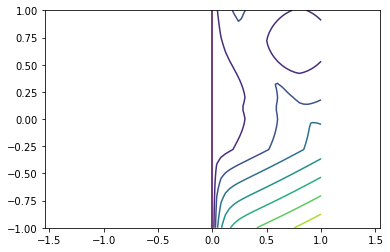

In [9]:
plt.axis('equal')
plt.contour(*X,hfmOut['values'].gradient(0));

The second perturbation influences the left part of the domain, as well as the rightmost seed value.

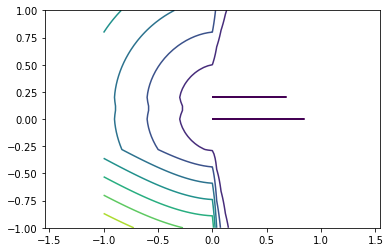

In [10]:
plt.axis('equal')
plt.contour(*X,hfmOut['values'].gradient(1));

By construction, the sum of these specific perturbations equals the value function.

In [11]:
assert norm_infinity(hfmOut['values'].value - hfmOut['values'].gradient().sum(axis=0)) < 1e-6

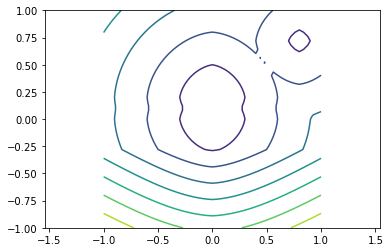

In [14]:
plt.axis('equal')
plt.contour(*X,hfmOut['values'].gradient().sum(axis=0));

We also test consistency with the CPU code.

In [15]:
hfmIn['mode'] = 'cpu_transfer'

In [16]:
hfmOut_cpu = hfmIn.Run()

Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.001 s.


In [17]:
assert norm_infinity(hfmOut_cpu['values'].gradient() - hfmOut['values'].gradient().get()) < 1e-5

### 1.2 Anisotropic model

In [18]:
hfmIn = Eikonal.dictIn({
    'model':'Dubins2',
    'exportValues':1,
    'seed':[0,0,0],
    'xi':1.,
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=101)
hfmIn.nTheta = 96
X = hfmIn.Grid()

In [38]:
costValue = (1.+(X[1]<-0.3)).astype(hfmIn.float_t) # (float32 + bool) -> float64 -> float32
costVariation = 1.+delta[0]*(X[0]>0.) + delta[1]*(X[0]<=0) # Relative variation
hfmIn['cost'] = costValue*costVariation

In [39]:
hfmIn['mode'] = 'gpu' #'cpu_transfer'

In [40]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.10249781608581543 seconds, and 186 iterations.
Post-Processing


In [46]:
val = hfmOut['values']
diff = np.where(np.isfinite(val), val.value - val.gradient().sum(axis=0), 0)

In [55]:
assert np.sum(diff>1e-4) / diff.size < 2e-3
assert np.max(diff/(1+val.value)) < 1e-2

## 2. Reverse differentiation

In [18]:
n=50
delta = ad.Dense.identity(constant=cp.zeros(2))
hfmIn = Eikonal.dictIn({
    'model':'Isotropic2',
    'seeds':[[0.,0.],[0.,0.5]],
#    'seeds':cp.array([[0.,0.],[0.8,0.7],[0.,0.2]]),
#    'seedValues':ad.array([0.*delta[0],0.2*(1.+delta[0]),0.*delta[0]]),
    'exportValues':1,
    'traits':{
        'shape_i':(8,8),'niter_i':16,
    },
    'cost':1.,
})
hfmIn.SetRect([[0,1],[0,1]],dimx=n+1,sampleBoundary=True)
X=hfmIn.Grid()

Casting output of function zeros from float64 to float32


In [20]:
sensShape= (*hfmIn.shape,1)
sens = cp.zeros(sensShape)
sens[-1,-1] = 1.
hfmIn['sensitivity'] = sens

Casting output of function zeros from float64 to float32


In [21]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.007498502731323242 seconds, and 11 iterations.
Post-Processing


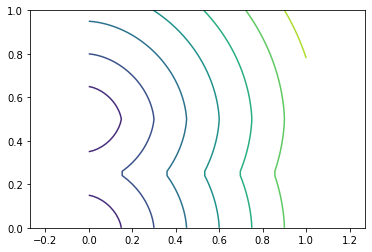

In [22]:
plt.axis('equal')
plt.contour(*X,hfmOut['values']);

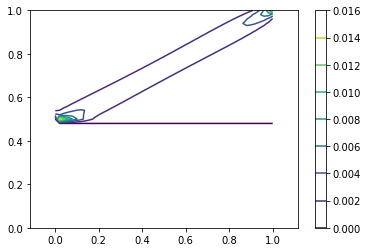

In [23]:
plt.axis('equal')
#cSens = hfmOut['costSensitivity'][0]; cSens[0,0]=0
plt.contour(*X,hfmOut['costSensitivity'][...,0]); plt.colorbar();

The tested point is only sensitive to the second seed value.

In [24]:
hfmOut['seedValueSensitivity']

array([[    0],
       [    1]], dtype=float32)

In [25]:
assert norm_infinity(hfmOut['seedValueSensitivity'] - cp.array([[0],[1]]))<1e-6